In [2]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

this_notebook_name = "ResUNet-BreastTumorSegmentationStudyTest"

# Update this folder name for your computer

train_timestamp = "2020-01-27_17-20-14"
local_data_folder = r"/home/justin/Desktop/BreastTumorSegmentationStudy"

overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

# Evaluation parameters

acceptable_margin_mm = 3.0
mm_per_pixel = 1.0
acceptable_margin_pixel = int(acceptable_margin_mm/mm_per_pixel)
roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

limit_rounds = 0

# Uncomment for faster debugging
roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01]
limit_rounds = 0

In [3]:
import glob
import os
import datetime
from random import sample

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
import math

import tensorflow as tf
import ResUNet_Model as resunet
# import ultrasound_batch_generator as generator
# import sagittal_spine_segmentation_unet as unet
import evaluation_metrics

from girder_apikey_read import girder_apikey_read
girder_api_url = "https://pocus.cs.queensu.ca/api/v1"

In [4]:
testing_ultrasound_ids = [
    "5e1cb685d9e6a3be02d01434", #006-v02
    "5e1cbf54d9e6a3be02d0144c", #012
    "5e1cca85d9e6a3be02d01464", #018
    "5e163f22d9e6a3be02d01398", #024
    #"5e1c99f3d9e6a3be02d0140d", #030
]

testing_ultrasound_filenames = [
    "ultrasound-006-v02.npy",
    "ultrasound-012.npy",
    "ultrasound-018.npy",
    "ultrasound-024.npy",
    #"ultrasound-030.npy",
]

testing_segmentation_ids = [
    "5e1cb684d9e6a3be02d01431", #006-v02
    "5e1cbf54d9e6a3be02d01449", #012
    "5e1cca84d9e6a3be02d01461", #018
    "5e163f21d9e6a3be02d01395", #024
    #"5e1c99eed9e6a3be02d013ec", #030
]

testing_segmentation_filenames = [
    "segmentation-006-v02.npy",
    "segmentation-012.npy",
    "segmentation-018.npy",
    "segmentation-024.npy",
    #"segmentation-030.npy",
]
# Default subfolders of main project data folder

data_arrays_folder      = "DataArrays"
notebooks_save_folder   = "SavedNotebooks"
models_folder           = "SavedModels"
results_save_folder     = "SavedResults"
test_predictions_folder = "PredictionsTest"

data_arrays_fullpath      = os.path.join(local_data_folder, data_arrays_folder)
notebooks_save_fullpath   = os.path.join(local_data_folder, notebooks_save_folder)
models_fullpath           = os.path.join(local_data_folder, models_folder)
results_save_fullpath     = os.path.join(local_data_folder, results_save_folder)
test_predictions_fullpath = os.path.join(local_data_folder, test_predictions_folder)

if not os.path.exists(data_arrays_fullpath):
    os.makedirs(data_arrays_fullpath)
    print("Created folder: {}".format(data_arrays_fullpath))

if not os.path.exists(notebooks_save_fullpath):
    os.makedirs(notebooks_save_fullpath)
    print("Created folder: {}".format(notebooks_save_fullpath))

if not os.path.exists(models_fullpath):
    raise FileNotFoundError(models_fullpath)

if not os.path.exists(results_save_fullpath):
    os.makedirs(results_save_fullpath)
    print("Created folder: {}".format(results_save_fullpath))

if not os.path.exists(test_predictions_fullpath):
    os.makedirs(test_predictions_fullpath)
    print("Created folder: {}".format(test_predictions_fullpath))

In [5]:
# Download data from Girder

time_download_start = datetime.datetime.now()

print("Downloading testing files ...")

# Preparing progress bar
n_files = len(testing_ultrasound_ids)
f = IntProgress(min=0, max=n_files*2)
display(f)

# Downloading files

gclient = girder_client.GirderClient(apiUrl=girder_api_url)
gclient.authenticate(apiKey=girder_apikey_read)

for i in range(n_files):
    testing_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filenames[i])
    if not os.path.exists(testing_ultrasound_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(testing_ultrasound_fullname))
        gclient.downloadFile(testing_ultrasound_ids[i], testing_ultrasound_fullname)
    f.value = i * 2 + 1
    
    testing_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filenames[i])
    if not os.path.exists(testing_segmentation_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(testing_segmentation_fullname))
        gclient.downloadFile(testing_segmentation_ids[i], testing_segmentation_fullname)
    f.value = i * 2 + 2

time_download_stop = datetime.datetime.now()
print("\nTotal download time: {}".format(time_download_stop - time_download_start))

IntProgress(value=0, max=8)


Total download time: 0:00:00.040499


In [6]:
# Read data into numpy arrays

test_ultrasound_arrays = []
test_segmentation_arrays = []

f = IntProgress(min=0, max=n_files * 2)
display(f)

time_start = datetime.datetime.now()

for i in range(n_files):
    testing_ultrasound_fullname = os.path.join(data_arrays_fullpath, testing_ultrasound_filenames[i])
    testing_segmentation_fullname = os.path.join(data_arrays_fullpath, testing_segmentation_filenames[i])

    testing_ultrasound_data = np.load(testing_ultrasound_fullname)
    f.value = i * 2 + 1
    
    testing_segmentation_data = np.load(testing_segmentation_fullname)
    f.value = i * 2 + 2
    
    test_ultrasound_arrays.append(testing_ultrasound_data)
    test_segmentation_arrays.append(testing_segmentation_data)

time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))

IntProgress(value=0, max=8)


Total time to load from files: 0:00:00.015677


In [7]:
filename_pattern = "*" + train_timestamp + "*"
search_string = os.path.join(models_fullpath, filename_pattern)
print("Searching for models by {}".format(search_string))
model_file_list = glob.glob(search_string)

num_models = len(model_file_list)
print("Found {} models".format(num_models))

if limit_rounds > 0:
    num_rounds = min(num_models, limit_rounds)
else:
    num_rounds = num_models

Searching for models by /home/justin/Desktop/BreastTumorSegmentationStudy/SavedModels/*2020-01-27_17-20-14*
Found 10 models


In [8]:
test_ultrasound_data = np.zeros(
        [0, test_ultrasound_arrays[0].shape[1], test_ultrasound_arrays[0].shape[2], test_ultrasound_arrays[0].shape[3]])
test_segmentation_data = np.zeros(
        [0, test_ultrasound_arrays[0].shape[1], test_ultrasound_arrays[0].shape[2], test_ultrasound_arrays[0].shape[3]])

for test_index in range(n_files):
    test_ultrasound_data = np.concatenate((test_ultrasound_data, test_ultrasound_arrays[test_index]))
    test_segmentation_data = np.concatenate((test_segmentation_data, test_segmentation_arrays[test_index]))

In [9]:
print("Number of models: ", num_models)
print("Testing ultrasound data shape:            {}".format(test_ultrasound_data.shape))
print("Using timestemp to find files: {}".format(train_timestamp))
print("Saving test predictions in:    {}".format(test_predictions_fullpath))

test_best_metrics    = dict()
test_fuzzy_metrics   = dict()
test_aurocs          = np.zeros(num_models)
test_best_thresholds = np.zeros(num_models)

Number of models:  10
Testing ultrasound data shape:            (961, 128, 128, 1)
Using timestemp to find files: 2020-01-27_17-20-14
Saving test predictions in:    /home/justin/Desktop/BreastTumorSegmentationStudy/PredictionsTest


In [10]:
# Main loop, test all models and save test results

#so we don't overflow the graph with nodes
from tensorflow.keras.backend import clear_session
time_sequence_start = datetime.datetime.now()

threshold=0.5
wcce = resunet.weighted_categorical_crossentropy([0.2, 0.8])

totDistanceErrs = []
totMissed = []
totSeg = []
img_FPs = []
img_FNs = []
img_TNs = []
img_TPs = []
img_ACCs = []

for i in range(num_models):
    count=0
    totDistanceErr = 0
    img_FP = 0
    img_FN = 0
    img_TN = 0
    img_TP = 0
    missed = []
    seg = []
    
    #Clear the session which contains graph nodes from the previous model. 
    #This speeds up testing and keeps each model uniform for testing time
    clear_session()
    time_round_start = datetime.datetime.now()
    
    print("Testing model: {}".format(model_file_list[i]))
    model = tf.keras.models.load_model(model_file_list[i], custom_objects={'loss': wcce, 'dice_coef': resunet.dice_coef})
    test_prediction = model.predict(test_ultrasound_data)
    
    '''
    Part 1 - remove predicted areas less than a threshold value
    '''
    test_prediction[:,:,:,0] = (test_prediction[:,:,:,0] > threshold)
    test_prediction[:,:,:,1] = (test_prediction[:,:,:,1] > threshold)
    #test_prediction[:,:,:,0] = 1-test_prediction[:,:,:,1]
    
    totImg = test_prediction.shape[0]
    for k in range(totImg):

        '''
        Part 2 - Contour removal and center distance calculation
        '''
        #find all contours of prediction
        pred_im2, pred_contours, pred_hierarchy = cv2.findContours(np.uint8(np.rint(test_prediction[k,:,:,1])),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        seg_im2, seg_contours, seg_hierarchy = cv2.findContours(np.uint8(np.rint(test_segmentation_data[k,:,:,0])),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        
        #some images may not have a contour predicted
        if len(pred_contours) !=0 and len(seg_contours) !=0:   
            #print("Length of contour array before removal:", len(pred_contours))
            #check if there are multiple
            if len(pred_contours)>1:
                contourAreas = []
                #there are multiple, create a mask of the image and use it to remove smallest contours
                mask = np.ones(test_prediction[k].shape[:2], dtype="uint8")
        
                #loop through each contour, find area
                for c in range(len(pred_contours)):
                    M = cv2.moments(pred_contours[c])
                    contourAreas.append(cv2.contourArea(pred_contours[c]))
        
                maxArea = max(contourAreas)
                #print("Contour areas (largest should be kept):", contourAreas)
                #find position of largest contour
                for c in range(len(contourAreas)):
                    if contourAreas[c] < maxArea:
                        #draw the smallest contours on the mask
                        cv2.drawContours(mask, [pred_contours[c]], -1,0,-1)
                        temp_contours = pred_contours.copy()
                        del temp_contours[c]
                pred_contours = temp_contours.copy()
                #create new img without the small contours
                img = cv2.bitwise_and(np.uint8(np.rint(test_prediction[k,:,:,1])), np.uint8(np.rint(test_prediction[k,:,:,1])), mask=mask)    
                #Last, we need to update the prediction to include only the one contour
                test_prediction[k,:,:,1] = img*test_prediction[k,:,:,1]
                
            #print("Length of contour array (should be 1):", len(pred_contours))
            #print("Contour length kept (should match largest):", cv2.contourArea(pred_contours[0]))
    
            #now we can find the centre of prediction and segmentation contours and compare distances
            M = cv2.moments(pred_contours[0])
            
            if M["m00"]!=0:
                pred_cX = int(M["m10"] / M["m00"])
                pred_cY = int(M["m01"] / M["m00"])

                #find the segmentation contour. We segmented so know theres only 1
                M = cv2.moments(seg_contours[0])
                seg_cX = int(M["m10"] / M["m00"])
                seg_cY = int(M["m01"] / M["m00"])
    
                #print(([pred_cX,pred_cY], [seg_cX, seg_cY]))
                #now we have pred [x,y] and seg [x,y]. Calculate the distance difference
                distance = math.sqrt((pred_cX - seg_cX)**2 + (pred_cY - seg_cY)**2)
                count+=1
                totDistanceErr += distance
    
    
            '''
            Part 3 - overlap calculation. Done inside the if statement so we only calculate if there is a segmentation
            '''
        
            #add margin to the prediction.
            accept_pred_map = evaluation_metrics.dilate_stack(test_prediction[k,:,:,1], acceptable_margin_pixel)
            accept_pos_map = test_segmentation_data[k,:,:,0]
            
            #sum together and take locations that are 2 (pred and seg are binary already)
            intersection_map = accept_pred_map + accept_pos_map
            #this returns a binary array (128x128) where 1 is the intersection, 0 is not
            intersection = (intersection_map==2)
            
            #Calculate area of intersection
            area_of_intersection = np.sum(intersection, dtype="float64")
            
            #Calculate area of segmentation
            area_of_segmentation = np.sum(test_segmentation_data[k,:,:,0], dtype="float64")
            
            #to avoid cases where there are no segmentations
            if area_of_segmentation==0: area_of_segmentation=1
                
            segRate = area_of_intersection/area_of_segmentation
            missedRate = 1-segRate
            
    
            #if there is a prediction, store the values
            seg.append(segRate)
            missed.append(missedRate)
            
    
        '''
        Part 4 - Calculate image-wide classification metrics
        '''
        #Now we will calculate the image-wide metrics
        if np.sum(test_segmentation_data[k,:,:,0]) == 0 and np.sum(test_prediction[k,:,:,1]) != 0:
            #print("predicted tumor but none ",i)
            img_FP +=1
        elif np.sum(test_segmentation_data[k,:,:,0]) !=0 and np.sum(test_prediction[k,:,:,1]) == 0:
            #print("predicted no tumor but tumor ",i)
            img_FN +=1
        elif np.sum(test_segmentation_data[k,:,:,0]) == 0 and np.sum(test_prediction[k,:,:,1]) == 0:
            #print("predicted no tumor and no tumor ",i)
            img_TN +=1
        elif np.sum(test_segmentation_data[k,:,:,0]) != 0 and np.sum(test_prediction[k,:,:,1]) != 0:
            #print("predicted some tumor and tumor ",i)
            img_TP +=1
        
    
    '''
    Part 5 - Store all metrics for model i
    '''
    if count == 0: count=1
    totDistanceErrs.append(totDistanceErr/count)
    
    if len(missed)==0: missed=[0]
    if len(seg)==0: seg=[0]
    totMissed.append(sum(missed)/len(missed))
    totSeg.append(sum(seg)/len(seg))
    img_TPs.append(img_TP)
    img_FPs.append(img_FP)
    img_FNs.append(img_FN)
    img_TNs.append(img_TN)
    img_ACCs.append((img_TP+img_TN)/(img_TP+img_TN+img_FN+img_FP))
    
    test_prediction_filename = train_timestamp + "_prediction_test.npy"
    test_prediction_fullname = os.path.join(test_predictions_fullpath, test_prediction_filename)
    np.save(test_prediction_fullname, test_prediction)
    
    '''
    Part 6 - Calculate any other metrics in the evaluation_metrics code
    '''
    # Test results
    
    test_metrics_dicts, test_best_threshold_index, test_area = evaluation_metrics.compute_roc(
        roc_thresholds, test_prediction, test_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    test_fuzzy_metrics[i] = evaluation_metrics.compute_evaluation_metrics(
        test_prediction, test_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    test_best_metrics[i]    = test_metrics_dicts[test_best_threshold_index]
    test_aurocs[i]          = test_area
    test_best_thresholds[i] = roc_thresholds[test_best_threshold_index]
    
    print("Testing round time: {}".format(datetime.datetime.now() - time_round_start))


time_sequence_stop = datetime.datetime.now()

print("\nTotal testing time:   {}".format(time_sequence_stop - time_sequence_start))

Testing model: /home/justin/Desktop/BreastTumorSegmentationStudy/SavedModels/ResUNet-BreastTumorSegmentationStudy_model-1_2020-01-27_17-20-14.h5
Testing round time: 0:00:38.756223
Testing model: /home/justin/Desktop/BreastTumorSegmentationStudy/SavedModels/ResUNet-BreastTumorSegmentationStudy_model-8_2020-01-27_17-20-14.h5
Testing round time: 0:00:37.529970
Testing model: /home/justin/Desktop/BreastTumorSegmentationStudy/SavedModels/ResUNet-BreastTumorSegmentationStudy_model-9_2020-01-27_17-20-14.h5
Testing round time: 0:00:40.150990
Testing model: /home/justin/Desktop/BreastTumorSegmentationStudy/SavedModels/ResUNet-BreastTumorSegmentationStudy_model-4_2020-01-27_17-20-14.h5
Testing round time: 0:00:39.672044
Testing model: /home/justin/Desktop/BreastTumorSegmentationStudy/SavedModels/ResUNet-BreastTumorSegmentationStudy_model-6_2020-01-27_17-20-14.h5
Testing round time: 0:00:39.162702
Testing model: /home/justin/Desktop/BreastTumorSegmentationStudy/SavedModels/ResUNet-BreastTumorSegm

In [11]:
# Arrange results in tables

#metric_labels = [
#    "Acc",
#    "AUROC",
#    "best thresh",
#    "best TP",
#    "best FP",
#    "best recall",
#    "best precis",
#    "best dice",
#    "fuzzy recall",
#    "fuzzy precis",
#    "fuzzy Fscore"
#]

metric_labels = [
    "Overall Acc",
    "Image Classification Acc",
    "Img Classification TP",
    "Img Classification FP",
    "Img Classification FN",
    "Img Classification TN",
    "Img Classification Sensitivity (TP/(TP+FN))",
    "Img Classification Specificity (TN/(TN+FP))",
    "Img Classification Precision (TP/(TP+FP))",
    "Avg Center Distance",
    "Avg Prediction Overlap",
    "Avg Missed Prediction",
    "Dice"    
]
results_labels = []

for label in metric_labels:
    results_labels.append("Test " + label)

    
results_df = pd.DataFrame(columns = results_labels)

for i in range(num_models):
    results_df.loc[i] = [
        test_best_metrics[i][evaluation_metrics.ACCURACY],
        img_ACCs[i],
        img_TPs[i],
        img_FPs[i],
        img_FNs[i],
        img_TNs[i],
        img_TPs[i]/(max(1,img_TPs[i]+img_FNs[i])),
        img_TNs[i]/(max(1,img_TNs[i]+img_FPs[i])),
        img_TPs[i]/(max(1,img_TPs[i]+img_FPs[i])),
        totDistanceErrs[i],
        totSeg[i],
        totMissed[i],
        #test_aurocs[i],
        #test_best_thresholds[i],
        #test_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
        #test_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
        #test_best_metrics[i][evaluation_metrics.RECALL],
        #test_best_metrics[i][evaluation_metrics.PRECISION],
        test_best_metrics[i][evaluation_metrics.DICE],
        #test_fuzzy_metrics[i][evaluation_metrics.RECALL],
        #test_fuzzy_metrics[i][evaluation_metrics.PRECISION],
        #test_fuzzy_metrics[i][evaluation_metrics.FSCORE],
    ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)

,Test Overall Acc,Test Image Classification Acc,Test Img Classification TP,Test Img Classification FP,Test Img Classification FN,Test Img Classification TN,Test Img Classification Sensitivity (TP/(TP+FN)),Test Img Classification Specificity (TN/(TN+FP)),Test Img Classification Precision (TP/(TP+FP)),Test Avg Center Distance,Test Avg Prediction Overlap,Test Avg Missed Prediction,Test Dice
0,0.993963,0.953174,848.0,18.0,27.0,68.0,0.969143,0.790698,0.979215,3.102657,0.889215,0.110785,0.763095
1,0.986416,0.971904,875.0,27.0,0.0,59.0,1.000000,0.686047,0.970067,4.663429,0.940874,0.059126,0.625839
2,0.994162,0.936524,830.0,16.0,45.0,70.0,0.948571,0.813953,0.981087,3.890157,0.792727,0.207273,0.730488
3,0.993721,0.975026,870.0,19.0,5.0,67.0,0.994286,0.779070,0.978628,3.771073,0.872550,0.127450,0.758151
4,0.990929,0.968783,875.0,30.0,0.0,56.0,1.000000,0.651163,0.966851,4.486573,0.915598,0.084402,0.701209
5,0.992840,0.963580,864.0,24.0,11.0,62.0,0.987429,0.720930,0.972973,4.438267,0.850780,0.149220,0.727015
6,0.992671,0.969823,869.0,23.0,6.0,63.0,0.993143,0.732558,0.974215,4.094113,0.892387,0.107613,0.732419
7,0.989017,0.969823,867.0,21.0,8.0,65.0,0.990857,0.755814,0.976351,3.587642,0.956283,0.043717,0.677734
8,0.987467,0.969823,872.0,26.0,3.0,60.0,0.996571,0.697674,0.971047,4.604102,0.919971,0.080029,0.635479
9,0.989639,0.967742,864.0,20.0,11.0,66.0,0.987429,0.767442,0.977376,3.766008,0.941370,0.058630,0.681779



Averages


Test Overall Acc                                      0.991083
Test Image Classification Acc                         0.964620
Test Img Classification TP                          863.400000
Test Img Classification FP                           22.400000
Test Img Classification FN                           11.600000
Test Img Classification TN                           63.600000
Test Img Classification Sensitivity (TP/(TP+FN))      0.986743
Test Img Classification Specificity (TN/(TN+FP))      0.739535
Test Img Classification Precision (TP/(TP+FP))        0.974781
Test Avg Center Distance                              4.040402
Test Avg Prediction Overlap                           0.897176
Test Avg Missed Prediction                            0.102824
Test Dice                                             0.703321
dtype: float64

In [12]:
# Save results table

csv_filename = this_notebook_name + "_" + train_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: /home/justin/Desktop/BreastTumorSegmentationStudy/SavedResults/ResUNet-BreastTumorSegmentationStudyTest_2020-01-27_17-20-14.csv


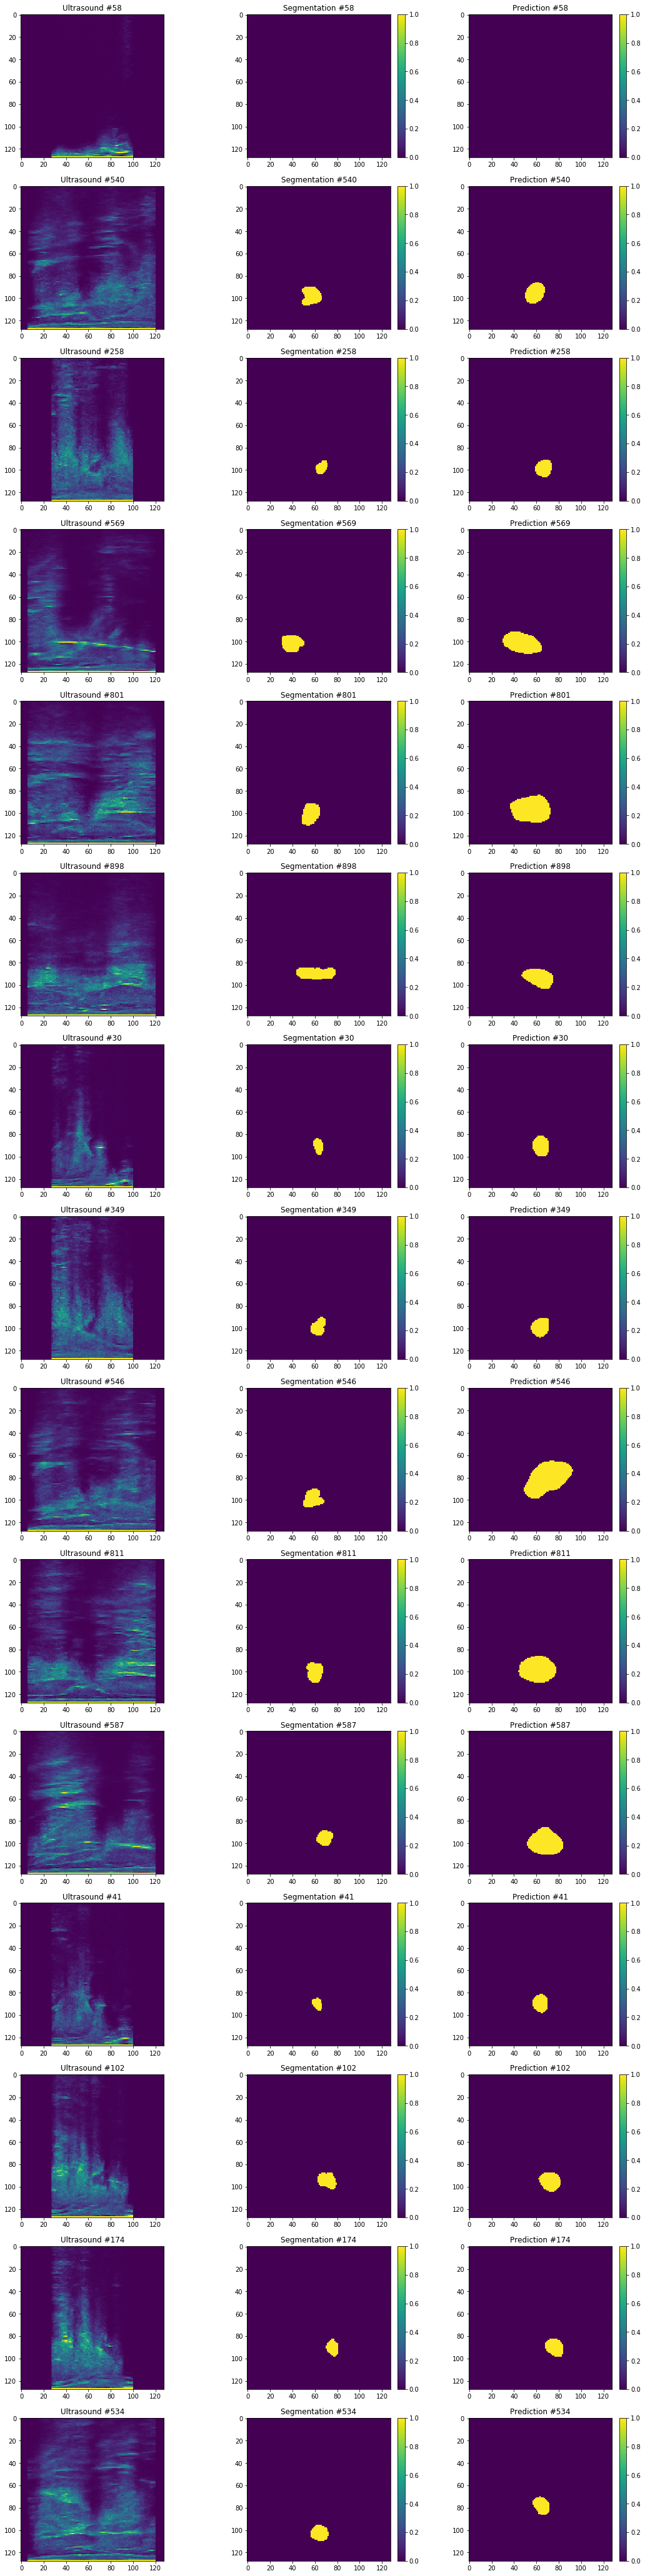

In [13]:
# Display sample results

num_test = test_ultrasound_data.shape[0]
num_show = 15

indices = [i for i in range(num_test)]
sample_indices = sample(indices, num_show)

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show,3,i*3+1)
    img0 = a0.imshow(test_ultrasound_data[sample_indices[i], :, :, 0].astype(np.float32))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show,3,i*3+2)
    img1 = a1.imshow(test_segmentation_data[sample_indices[i], :, :, 0], vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show,3,i*3+3)
    img2 = a2.imshow(test_prediction[sample_indices[i], :, :, 1], vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)

In [14]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [15]:
# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + train_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: /home/justin/Desktop/BreastTumorSegmentationStudy/SavedNotebooks/ResUNet-BreastTumorSegmentationStudyTest_2020-01-27_17-20-14.html
